In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from IPython.display import Image
import zipfile
from google.colab import drive
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.utils import shuffle
from skimage import filters
from skimage.color import rgb2gray
from scipy.linalg import svd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn import datasets
drive.mount('/content/drive/',force_remount=True)
!ls "/content/drive/My Drive"

Mounted at /content/drive/
'294 Essay Monalisha Parida.gdoc'	    'Getting started.pdf'
 animals				     ml100k
 ch1+os+introduction.ppt		     ml-1m
 ch2+os+structure.ppt			     Monalisha_parida_014637844.pdf
 ch3+processes.ppt			     Random_Images
 cmpe+180c+lecture+0+class+information.ppt   Test_Data
'Colab Notebooks'			     train


In [ ]:

header = ['User_ID', 'Age', 'Sex', 'Occupation', 'ZIP_Code']
path='/content/drive/My Drive/ml100k/u.user'
users = pd.read_csv(path, sep='|', names=header)
#print('Number of users = ' + str(users) + ' | Number of movies = ' + str(n_items))

In [ ]:
users.shape

(943, 5)

In [ ]:
users.head()

,User_ID,Age,Sex,Occupation,ZIP_Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
import pandas as pd
header = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
path='/content/drive/My Drive/ml100k/u.data'
ratings = pd.read_csv(path, sep='\t', names=header)
df=ratings
n_users = df.User_ID.unique().shape[0]
n_items = df.Movie_ID.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))


Number of users = 943 | Number of movies = 1682


In [ ]:
ratings.shape

(100000, 4)

In [ ]:
ratings.head()

,User_ID,Movie_ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
len(ratings['Movie_ID'].unique())

1682

There are 943 unique users and 1682 unique movies; so we need to prepare an matrix of size 943 by 1682.


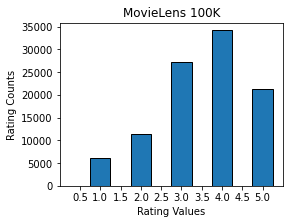

In [ ]:
nb_users  = users['User_ID'].nunique()
nb_movies = ratings['Movie_ID'].nunique()
print("There are %d unique users and %d unique movies; so we need to prepare " 
      "an matrix of size %d by %d." %(nb_users, nb_movies, nb_users, nb_movies))
plt.figure(figsize=(4,3))
bin_edges = np.arange(0.25,5.5,0.5)
plt.hist(ratings["Rating"],bins = bin_edges,edgecolor="k",rwidth=1)
plt.title('MovieLens 100K')
plt.xlabel('Rating Values')
plt.ylabel('Rating Counts')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

(943, 1682)
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


Text(0.5, 1.0, 'User Item Matrix for Movielens 100k')

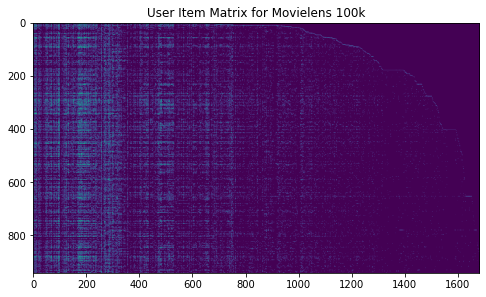

In [ ]:
from sklearn.model_selection import train_test_split
train_rating, test_rating =train_test_split(ratings,test_size=0.1)
ratings_matrix = ratings.pivot_table(index=['User_ID'],columns=['Movie_ID'],values='Rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = np.array(ratings_matrix)
Test_matrix = test_rating.pivot_table(index=['User_ID'],columns=['Movie_ID'],values='Rating').reset_index(drop=True)
Test_matrix.fillna(0, inplace = True)
Test_matrix = np.array(Test_matrix)
print(ratings_matrix.shape)
print(ratings_matrix)
plt.figure(figsize=[8,8])
plt.imshow(ratings_matrix)
S_D=len(np.where(ratings_matrix==0)[0])/(943*1682)
plt.title('User Item Matrix for Movielens 100k')

In [ ]:
m_cols = ['Movie_ID', 'Title', 'Release_Date', 'Video_Release_Date', 'IMDB_URL']
path='/content/drive/My Drive/ml100k/u.item'
movies = pd.read_csv(path, sep='|', names=m_cols, usecols=range(5),encoding='latin-1')
movies.head(10)
movie_id = movies[movies['Title'] == 'Toy Story (1995)']['Movie_ID'].values.item()
print("Movie ID is:", movie_id)

Movie ID is: 1


In [ ]:
user_id = [6, 10, 21, 59, 84]
users_recommend = users[users['User_ID'].isin(user_id)]
users_recommend

,User_ID,Age,Sex,Occupation,ZIP_Code
5,6,42,M,executive,98101
9,10,53,M,lawyer,90703
20,21,26,M,writer,30068
58,59,49,M,educator,08403
83,84,32,M,executive,55369


In [ ]:
users.tail()

,User_ID,Age,Sex,Occupation,ZIP_Code
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209
942,943,22,M,student,77841


In [ ]:
movie_id = [21, 27, 81, 88, 95]
movie_recommend = movies[movies['Movie_ID'].isin(movie_id)]
movie_recommend

,Movie_ID,Title,Release_Date,Video_Release_Date,IMDB_URL
20,21,Muppet Treasure Island (1996),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Muppet%20Trea...
26,27,Bad Boys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Bad%20Boys%20...
80,81,"Hudsucker Proxy, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Hudsucker%20P...
87,88,Sleepless in Seattle (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sleepless%20i...
94,95,Aladdin (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Aladdin%20(1992)


# **Making some rating zero in Rating Matrix to calculate RMSE/MAE**

In [ ]:
import copy
#def data_split(ratings_matrix,)
num_item=len(ratings_matrix.T)
num_users=len(ratings_matrix)
Train_matrix=copy.deepcopy(ratings_matrix)
print(Train_matrix.shape)
test_item=np.random.choice(num_item,int(num_item*0.70),replace=False)
test_user=np.random.choice(num_users,int(num_users*.70),replace=False)
for i,j in zip(test_user,test_item):
      Train_matrix[i][j]=0
print(len(test_item))
print(len(test_user))

(943, 1682)
1177
660


In [ ]:
# Function to calculate combine Jaccard & Triangle Similarity
from scipy.spatial.distance import pdist,squareform
def Calculate_CTJ(Data_Matrix,Alpha):
    bb=np.array(Data_Matrix)
    Jaccard_Similarity_Matrix=np.zeros((bb.shape[0],bb.shape[0]))
    Traingle_Similarity_Matrix= np.zeros((bb.shape[0],bb.shape[0]))
    Combined_Similarity_Matrix=np.zeros((bb.shape[0],bb.shape[0]))
    Jcc=squareform(pdist(Data_Matrix, metric='jaccard'))
    #Jcc=1 - pairwise_distances(Data_Matrix, metric = "hamming")
    Jcc=np.array(Jcc)
    for i in range(0,bb.shape[0]):
        for j in range(0,bb.shape[0]):
            a=bb[i,:]
            b=bb[j,:]
            Traingle_Similarity_Matrix[i,j]=1-(np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b)))
            Traingle_Similarity_Matrix[j,i]=Traingle_Similarity_Matrix[i,j]
            Intersection=len(list([i for i,val in enumerate(a==b) if val]))
            union=(len(a)+len(b))-Intersection
            #Jaccard_Similarity_Matrix[i,j]=float(Intersection)/union
            #Jaccard_Similarity_Matrix[j,i]=Jaccard_Similarity_Matrix[i,j]
            Combined_Similarity_Matrix[i,j]=Alpha*Jcc[i,j]*(Traingle_Similarity_Matrix[i,j]+1) # Equation 10
            Combined_Similarity_Matrix[j,i]=Combined_Similarity_Matrix[i,j]
    #plt.figure(figsize=[8,8])
    #plt.imshow(Combined_Similarity_Matrix)
    return Combined_Similarity_Matrix

# **K_NN based CF**

(100000,)


array([0, 1, 0, ..., 3, 0, 0], dtype=int32)

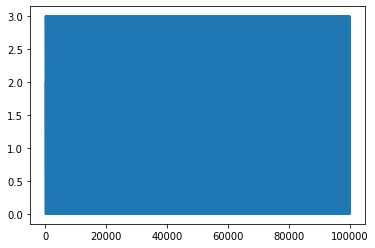

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
kmeans = KMeans(n_clusters=4)
# use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(ratings)
print(predictions.shape)
frame = pd.DataFrame(ratings)
frame['cluster'] = predictions
frame=frame['cluster'].to_numpy()
frame
plt.plot(predictions)
#ratings
predictions

In [ ]:
#user clustering matrix. Algorithm form the paper part 1
data_matrix=np.array(Train_matrix)
cluster_user_item_matrix= [ [None]*4 for i in range(len(data_matrix[0]))]
k=4
for  j in range(0, len(data_matrix[0])):
        for i in range(0,len(data_matrix)):
            if data_matrix[i,j]>0:
                if cluster_user_item_matrix[j][frame[i]]==None:
                    cluster_user_item_matrix[j][frame[i]]=[]
                cluster_user_item_matrix[j][frame[i]].append(data_matrix[i,j])
for i in range(0, len(cluster_user_item_matrix)):
    for j in range(0, len(cluster_user_item_matrix[0])):
        if cluster_user_item_matrix[i][j] != None:
            cluster_user_item_matrix[i][j] = np.nanmean(cluster_user_item_matrix[i][j])
new_frame_KNN = pd.DataFrame(cluster_user_item_matrix)
new_frame_KNN.fillna(0, inplace=True)
new_frame_KNN

,0,1,2,3
0,3.855172,3.831933,3.966292,3.888889
1,3.108108,3.275862,3.166667,3.268293
2,3.035714,2.814815,3.111111,3.294118
3,3.586207,3.566667,3.513514,3.518519
4,3.172414,3.583333,3.000000,3.350000
...,...,...,...,...
1677,0.000000,0.000000,1.000000,0.000000
1678,0.000000,0.000000,3.000000,0.000000
1679,0.000000,0.000000,2.000000,0.000000
1680,0.000000,0.000000,0.000000,3.000000


Sparsity For Original : 93.69533063577546
Sparsity For KNN : 13.15398335315101


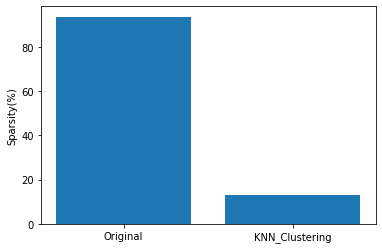

In [ ]:
S_KNN=len(np.where(new_frame_KNN==0)[0])/(4*1682)
Method=['Original','KNN_Clustering']
Sparsity=[S_D*100,S_KNN*100]
plt.bar(Method,Sparsity)
plt.ylabel('Sparsity(%)')
print('Sparsity For Original : ' + str(S_D*100 ))
print('Sparsity For KNN : ' + str(S_KNN*100 ))

In [ ]:
Similarity_Matrix_KNN=Calculate_CTJ(new_frame_KNN,0.5)
#Similarity_Matrix_KNN=1 - pairwise_distances(new_frame_KNN, metric = "hamming")
Similarity_Matrix_KNN=pd.DataFrame(Similarity_Matrix_KNN)

In [ ]:
#making a tuple of mean,similarity used as input to the priority Q used to predict based on KNN 
user_id=66
movie_id=888
#ratings_to_calculateMean=pd.DataFrame(ratings_to_calculateMean)
def rating_to_similarity(user_id,movie_id):
    list_rating_to_similarity = []
    for i in range(len(Similarity_Matrix_KNN[2])):
        list_rating_to_similarity.append(((ratings_to_calculateMean.T.values[user_id][i], Similarity_Matrix_KNN.values[movie_id][i],i)))
    return list_rating_to_similarity

In [ ]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_to_calculateMean = pd.read_csv('/content/drive/My Drive/ml100k/u.data', sep='\t', names=rating_cols)
#ratings_to_calculateMean = pd.read_csv(path, sep='\t', names=rating_cols)
ratings_to_calculateMean = ratings_to_calculateMean.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_to_calculateMean.fillna( 0, inplace = True )
ratings_to_calculateMean.shape

(1682, 943)

In [ ]:
import queue
class Qcomparater:
    def __init__(self, value):
        self.value = value
   
    def __lt__(self, other):
        return self.value[1]<other.value[1]
class Solution(object):
    def topKFrequent(self, nums, k,movie_id):
        """
        :type nums: List[int]
        :type k: int
        :rtype: List[int]
        """   
        pq = queue.PriorityQueue()  
        for i in nums:
            if i[0]==0.0:
                continue
            item = Qcomparater(i)
            pq.put(item)
           
            if pq.qsize() > k:
                pq.get()  
        numerator=0
        denominator=0
        for i in range(k):
            x=pq.get().value
            numerator+=(x[0]-np.nanmean(ratings_to_calculateMean.T[x[2]]))*x[1]
            denominator+=x[1]
        prediction=np.nanmean(ratings_to_calculateMean.T[movie_id]+(numerator/denominator))   
        print('Predition :' + str(prediction))
        print("---------------")
        return prediction       
x=Solution()
list_rating_to_similarity=rating_to_similarity(user_id,movie_id)
x.topKFrequent(list_rating_to_similarity,20,movie_id)
#k=no of neighbours,movie_id=movie_id

Predition :3.103928357845064
---------------


3.103928357845064

In [ ]:
ratings_matrix=np.array(ratings_matrix)
user=[]
movie=[]
print(len(test_item))
print(len(test_user))
for i, j in zip(test_user, test_item):
      if (ratings_matrix[i,j] > 0):
        user.append(i)
        movie.append(j)
user=np.array(user)
movie=np.array(movie)
print(len(user))
print(len(movie))

1177
660
47
47


In [ ]:
a=[]
b=[]
for i,j in zip(user,movie):
      Original=ratings_matrix[i,j]
      a.append(Original)
      print('Original rating '+str(Original))
      list_rating_to_similarity=rating_to_similarity(i,j)
      prediction=x.topKFrequent(list_rating_to_similarity,20,j)
      b.append(prediction)

Original rating 4.0
Predition :4.697229411081658
---------------
Original rating 5.0
Predition :3.3660860557803076
---------------
Original rating 4.0
Predition :3.5649461323635294
---------------
Original rating 2.0
Predition :2.971536678063714
---------------
Original rating 4.0
Predition :3.8915483584513155
---------------
Original rating 3.0
Predition :3.8775493575024407
---------------
Original rating 2.0
Predition :2.2201639881064867
---------------
Original rating 4.0
Predition :3.200757947024831
---------------
Original rating 2.0
Predition :2.4215054727019254
---------------
Original rating 4.0
Predition :3.417913751116707
---------------
Original rating 2.0
Predition :2.3043358558595677
---------------
Original rating 3.0
Predition :3.3662603644118936
---------------
Original rating 2.0
Predition :2.7248468729698874
---------------
Original rating 5.0
Predition :4.860607446714052
---------------
Original rating 3.0
Predition :1.4999711027113949
---------------
Original rating

In [ ]:
a=np.array(a)
b=np.array(b)
MAE=(1/len(a))*np.sum(np.abs(b-a))
print('Mean absolute Error is :' + str(MAE))

Mean absolute Error is :0.6787977226257201


In [ ]:
# K value changed from 1 to 25
a=[]
b=[]
for i,j in zip(user,movie):
      Original=ratings_matrix[i,j]
      a.append(Original)
      list_rating_to_similarity=rating_to_similarity(i,j)
      for k in range(1,25):
          print('For k = ' +str(k))
          print('Original rating '+str(Original))
          prediction=x.topKFrequent(list_rating_to_similarity,k,j)
          b.append(prediction)
a=np.array(a)
b=np.array(b)

For k = 1
Original rating 4.0
Predition :2.869565217391304
---------------
For k = 2
Original rating 4.0
Predition :4.488413316069108
---------------
For k = 3
Original rating 4.0
Predition :4.110972182132483
---------------
For k = 4
Original rating 4.0
Predition :3.9356707993590625
---------------
For k = 5
Original rating 4.0
Predition :3.81402256948907
---------------
For k = 6
Original rating 4.0
Predition :4.015864655422996
---------------
For k = 7
Original rating 4.0
Predition :4.138598411233309
---------------
For k = 8
Original rating 4.0
Predition :4.139697661911166
---------------
For k = 9
Original rating 4.0
Predition :4.090775540017818
---------------
For k = 10
Original rating 4.0
Predition :4.0870050191101015
---------------
For k = 11
Original rating 4.0
Predition :4.241490271398207
---------------
For k = 12
Original rating 4.0
Predition :4.300522225193328
---------------
For k = 13
Original rating 4.0
Predition :4.225660759780015
---------------
For k = 14
Original 

In [ ]:
bb=b.reshape(len(movie),20)
Error_KNN=[]
for k in range(0,20):
  M=(1/len(a))*np.sum(np.abs(bb[:,k]-a))
  Error_KNN.append(M)
plt.plot(Error_KNN)
plt.xlabel('No of nearest neighbor')
plt.ylabel('MAE')

NameError: ignored

# **Gaussian Mixture Model**

In [ ]:
#Generating figure 4a
k=4
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=k)
gmm.fit(ratings)
labels = gmm.predict(ratings)
frame = pd.DataFrame(ratings)
frame['cluster'] = labels
frame
ratings_matrix=np.array(ratings_matrix)
ratings_matrix[0,0]
frame=frame['cluster'].to_numpy()
frame
print(labels)

[2 0 2 ... 1 2 2]


In [ ]:
#user clustering matrix. Algorithm form the paper part 1
k=4
data_matrix=np.array(Train_matrix)
cluster_user_item_matrix= [[None]*k for i in range(len(data_matrix[0]))]
for  j in range(0, len(data_matrix[0])):
        for i in range(0,len(Train_matrix)):
            if data_matrix[i,j]>0:
                if cluster_user_item_matrix[j][frame[i]]==None:
                    cluster_user_item_matrix[j][frame[i]]=[]
                cluster_user_item_matrix[j][frame[i]].append(i)
#cluster_user_item_matrix
print(np.array(cluster_user_item_matrix).shape)

(1682, 4)


In [ ]:
#calculating mean, ref [36] page 3 para 1
for i in range(0, len(cluster_user_item_matrix)):
    for j in range(0, len(cluster_user_item_matrix[0])):
        if cluster_user_item_matrix[i][j] != None:
            cluster_user_item_matrix[i][j] = np.nanmean(cluster_user_item_matrix[i][j])
            
cluster_user_item_matrix = pd.DataFrame(cluster_user_item_matrix)

cluster_user_item_matrix.fillna(0, inplace=True)
cluster_user_item_matrix
#converting to df, filling na with 0
new_frame_GMM = pd.DataFrame(cluster_user_item_matrix)
new_frame_GMM.fillna(0, inplace=True)

[93.69533063577546, 13.15398335315101, 13.18370986920333]
[93.69533063577546, 13.15398335315101, 13.18370986920333]


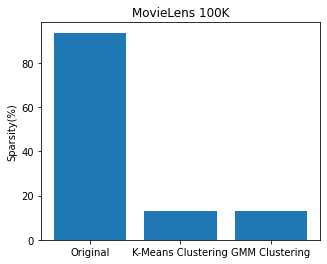

In [ ]:
S_GMM=len(np.where(new_frame_GMM==0)[0])/(4*1682)
Method=['Original','K-Means Clustering','GMM Clustering']
Sparsity=[S_D*100,S_KNN*100,S_GMM*100]
plt.figure(figsize=[5,4])
plt.bar(Method,Sparsity)
plt.ylabel('Sparsity(%)')
print(Sparsity)
plt.title('MovieLens 100K')
print(Sparsity)

In [ ]:
#similarity calculation, custom function to impliment Combined Triangle & Jaccard Similarity
Similarity_Matrix_GMM=Calculate_CTJ(new_frame_GMM,0.5)
#Similarity_Matrix_GMM=1 - pairwise_distances(new_frame_GMM, metric = "hamming")
Similarity_Matrix_GMM=pd.DataFrame(Similarity_Matrix_GMM)

In [ ]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_to_calculateMean = pd.read_csv('/content/drive/My Drive/ml100k/u.data', sep='\t', names=rating_cols)
#ratings_to_calculateMean = pd.read_csv(path, sep='\t', names=rating_cols)
ratings_to_calculateMean = ratings_to_calculateMean.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_to_calculateMean.fillna( 0, inplace = True )
ratings_to_calculateMean.shape

(1682, 943)

In [ ]:
#making a tuple of mean,similarity used as input to the priority Q used to predict based on KNN 
user_id=66
movie_id=888
#ratings_to_calculateMean=pd.DataFrame(ratings_to_calculateMean)
def rating_to_similarity(user_id,movie_id):
    list_rating_to_similarity = []
    for i in range(len(Similarity_Matrix_GMM[2])):
        list_rating_to_similarity.append(((ratings_to_calculateMean.T.values[user_id][i], Similarity_Matrix_GMM.values[movie_id][i],i)))
    return list_rating_to_similarity

In [ ]:
import queue
class Qcomparater:
    def __init__(self, value):
        self.value = value
   
    def __lt__(self, other):
        return self.value[1]<other.value[1]
class Solution(object):
    def topKFrequent(self, nums, k,movie_id):
        """
        :type nums: List[int]
        :type k: int
        :rtype: List[int]
        """   
        pq = queue.PriorityQueue()  
        for i in nums:
            if i[0]==0.0:
                continue
            item = Qcomparater(i)
            pq.put(item)
           
            if pq.qsize() > k:
                pq.get()  
        numerator=0
        denominator=0
        for i in range(k):
            x=pq.get().value
            numerator+=(x[0]-np.nanmean(ratings_to_calculateMean.T[x[2]]))*x[1]
            denominator+=x[1]
        prediction=np.nanmean(ratings_to_calculateMean.T[movie_id]+(numerator/denominator))   
        print('Predition :' + str(prediction))
        print("---------------")
        return prediction       
x=Solution()
list_rating_to_similarity=rating_to_similarity(user_id,movie_id)
x.topKFrequent(list_rating_to_similarity,25,movie_id)
#k=no of neighbours,movie_id=movie_id

Predition :3.0383948397224825
---------------


3.0383948397224825

# **Calculating Mean Absolute Error**

In [ ]:
ratings_matrix=np.array(ratings_matrix)
user=[]
movie=[]
print(len(test_item))
print(len(test_user))
for i, j in zip(test_user, test_item):
      if (ratings_matrix[i,j] > 0):
        user.append(i)
        movie.append(j)
user=np.array(user)
movie=np.array(movie)
print(len(user))
print(len(movie))

1177
660
47
47


In [ ]:
a=[]
b=[]
for i,j in zip(user,movie):
      Original=ratings_matrix[i,j]
      a.append(Original)
      print('Original rating '+str(Original))
      list_rating_to_similarity=rating_to_similarity(i,j)
      prediction=x.topKFrequent(list_rating_to_similarity,20,j)
      b.append(prediction)

Original rating 4.0
Predition :4.06527425725827
---------------
Original rating 5.0
Predition :3.8287886390909645
---------------
Original rating 4.0
Predition :3.4465773374409903
---------------
Original rating 2.0
Predition :3.11539411649961
---------------
Original rating 4.0
Predition :3.9110878218202068
---------------
Original rating 3.0
Predition :3.339236580135302
---------------
Original rating 2.0
Predition :2.75490524170005
---------------
Original rating 4.0
Predition :2.8741251737427875
---------------
Original rating 2.0
Predition :3.1098782517663492
---------------
Original rating 4.0
Predition :3.1323585999393417
---------------
Original rating 2.0
Predition :3.107148707131967
---------------
Original rating 3.0
Predition :3.405517556116392
---------------
Original rating 2.0
Predition :3.0994936609512833
---------------
Original rating 5.0
Predition :4.402786778336674
---------------
Original rating 3.0
Predition :2.121377784397319
---------------
Original rating 2.0
P

In [ ]:
a=np.array(a)
b=np.array(b)
MAE=(1/len(a))*np.sum(np.abs(b-a))
print('Mean absolute Error is :' + str(MAE))

Mean absolute Error is :0.7294994425547885


# **Changing the K Value**

In [ ]:
# K value changed from 1 to 25
a=[]
b=[]
for i,j in zip(user,movie):
      Original=ratings_matrix[i,j]
      a.append(Original)
      list_rating_to_similarity=rating_to_similarity(i,j)
      for k in range(1,21):
          print('For k = ' +str(k))
          print('Original rating '+str(Original))
          prediction=x.topKFrequent(list_rating_to_similarity,k,j)
          b.append(prediction)
a=np.array(a)
b=np.array(b)

For k = 1
Original rating 4.0
Predition :2.869565217391304
---------------
For k = 2
Original rating 4.0
Predition :4.488413316069108
---------------
For k = 3
Original rating 4.0
Predition :4.110972182132483
---------------
For k = 4
Original rating 4.0
Predition :3.9356707993590625
---------------
For k = 5
Original rating 4.0
Predition :3.81402256948907
---------------
For k = 6
Original rating 4.0
Predition :4.015864655422996
---------------
For k = 7
Original rating 4.0
Predition :4.138598411233309
---------------
For k = 8
Original rating 4.0
Predition :4.139697661911166
---------------
For k = 9
Original rating 4.0
Predition :4.090775540017818
---------------
For k = 10
Original rating 4.0
Predition :4.0870050191101015
---------------
For k = 11
Original rating 4.0
Predition :4.241490271398207
---------------
For k = 12
Original rating 4.0
Predition :4.300522225193328
---------------
For k = 13
Original rating 4.0
Predition :4.225660759780015
---------------
For k = 14
Original 

Text(0, 0.5, 'MAE')

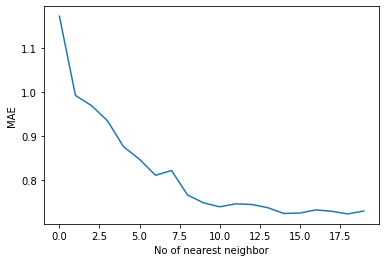

In [ ]:
bb=b.reshape(len(movie),20)
Error=[]
for k in range(0,20):
  M=(1/len(a))*np.sum(np.abs(bb[:,k]-a))
  Error.append(M)
plt.plot(Error)
plt.xlabel('No of nearest neighbor')
plt.ylabel('MAE')

In [ ]:
Method=['K-Means + Jaccard','K-Means + CTJ','GMM + Jaccard','GMM + CTJ']
MAE_M=[0.836,0.808,0.918,0.768]
plt.figure(figsize=[4,4])
plt.barh(Method,MAE_M)
plt.title('MovieLens 100k')
plt.xlabel('MAE')
plt.xlim(0.6,1)

Text(0, 0.5, 'Accuracy')

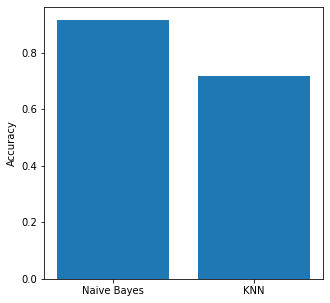

In [ ]:
import matplotlib.pyplot as plt
Method=['Naive Bayes','KNN']
MAE_M=[0.916,0.718]
plt.figure(figsize=[5,5])
plt.bar(Method,MAE_M)
plt.ylabel('Accuracy')

# **Without Any Clustering**

In [ ]:
#similarity calculation, custom function to impliment Combined Triangle & Jaccard Similarity
Similarity_Matrix_NC=Calculate_CTJ(data_matrix.T,0.5)
Similarity_Matrix_NC=pd.DataFrame(Similarity_Matrix_NC)

In [ ]:
Similarity_Matrix_NC.shape

(1682, 1682)

In [ ]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_to_calculateMean = pd.read_csv('/content/drive/My Drive/ml100k/u.data', sep='\t', names=rating_cols)
#ratings_to_calculateMean = pd.read_csv(path, sep='\t', names=rating_cols)
ratings_to_calculateMean = ratings_to_calculateMean.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_to_calculateMean.fillna( 0, inplace = True )
ratings_to_calculateMean.shape

(1682, 943)

In [ ]:
#making a tuple of mean,similarity used as input to the priority Q used to predict based on KNN 
user_id=66
movie_id=888
#ratings_to_calculateMean=pd.DataFrame(ratings_to_calculateMean)
def rating_to_similarity(user_id,movie_id):
    list_rating_to_similarity = []
    for i in range(len(Similarity_Matrix_NC[2])):
        list_rating_to_similarity.append(((ratings_to_calculateMean.T.values[user_id][i], Similarity_Matrix_NC.values[movie_id][i],i)))
    return list_rating_to_similarity

In [ ]:
import queue
class Qcomparater:
    def __init__(self, value):
        self.value = value
   
    def __lt__(self, other):
        return self.value[1]<other.value[1]
class Solution(object):
    def topKFrequent(self, nums, k,movie_id):
        """
        :type nums: List[int]
        :type k: int
        :rtype: List[int]
        """   
        pq = queue.PriorityQueue()  
        for i in nums:
            if i[0]==0.0:
                continue
            item = Qcomparater(i)
            pq.put(item)
           
            if pq.qsize() > k:
                pq.get()  
        numerator=0
        denominator=0
        for i in range(k):
            x=pq.get().value
            numerator+=(x[0]-np.nanmean(ratings_to_calculateMean.T[x[2]]))*x[1]
            denominator+=x[1]
        prediction=np.nanmean(ratings_to_calculateMean.T[movie_id]+(numerator/denominator))   
        print('Predition :' + str(prediction))
        print("---------------")
        return prediction       
x=Solution()
list_rating_to_similarity=rating_to_similarity(user_id,movie_id)
x.topKFrequent(list_rating_to_similarity,25,movie_id)
#k=no of neighbours,movie_id=movie_id

Predition :3.219628607476161
---------------


3.219628607476161

In [ ]:
ratings_matrix=np.array(ratings_matrix)
user=[]
movie=[]
print(len(test_item))
print(len(test_user))
for i, j in zip(test_user, test_item):
      if (ratings_matrix[i,j] > 0):
        user.append(i)
        movie.append(j)
user=np.array(user)
movie=np.array(movie)
print(len(user))
print(len(movie))

841
471
26
26


In [ ]:
a=[]
b=[]
for i,j in zip(user,movie):
      Original=ratings_matrix[i,j]
      a.append(Original)
      print('Original rating '+str(Original))
      list_rating_to_similarity=rating_to_similarity(i,j)
      prediction=x.topKFrequent(list_rating_to_similarity,4,j)
      b.append(prediction)

Original rating 4.0
Predition :4.352365992573242
---------------
Original rating 4.0
Predition :3.330429265356974
---------------
Original rating 5.0
Predition :4.316034326614252
---------------
Original rating 4.0
Predition :3.8914089890329873
---------------
Original rating 3.0
Predition :2.8876245429599416
---------------
Original rating 2.0
Predition :3.109588226726006
---------------
Original rating 5.0
Predition :4.792036001243857
---------------
Original rating 4.0
Predition :3.9889929238153945
---------------
Original rating 3.0
Predition :2.5044531015886187
---------------
Original rating 4.0
Predition :3.5984981579931175
---------------
Original rating 3.0
Predition :3.030024173564489
---------------
Original rating 3.0
Predition :2.8110890899597325
---------------
Original rating 5.0
Predition :4.603654187707661
---------------
Original rating 4.0
Predition :3.4196325033472252
---------------
Original rating 4.0
Predition :3.98187941017363
---------------
Original rating 3.0

In [ ]:
a=np.array(a)
b=np.array(b)
MAE=(1/len(a))*np.sum(np.abs(b-a))
print('Mean absolute Error is :' + str(MAE))

Mean absolute Error is :0.3351235178452736


Code Snipet

In [ ]:
def Calculate_CTJ(Data_Matrix,Alpha):
    bb=np.array(Data_Matrix)
    Jaccard_Similarity_Matrix=np.zeros((bb.shape[0],bb.shape[0]))
    Traingle_Similarity_Matrix= np.zeros((bb.shape[0],bb.shape[0]))
    Combined_Similarity_Matrix=np.zeros((bb.shape[0],bb.shape[0]))
    for i in range(0,bb.shape[0]):
        for j in range(0,bb.shape[0]):
            a=bb[i,:]
            b=bb[j,:]
            Traingle_Similarity_Matrix[i,j]=1-(np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b)))
            Traingle_Similarity_Matrix[j,i]=Traingle_Similarity_Matrix[i,j]
            Intersection=len(list([i for i,val in enumerate(a==b) if val]))
            union=(len(a)+len(b))-Intersection
            Jaccard_Similarity_Matrix[i,j]=float(Intersection)/union
            Jaccard_Similarity_Matrix[j,i]=Jaccard_Similarity_Matrix[i,j]
            Combined_Similarity_Matrix[i,j]=Alpha*Jaccard_Similarity_Matrix[j,i]*(Traingle_Similarity_Matrix[i,j]+1) # Equation 10
            Combined_Similarity_Matrix[j,i]=Combined_Similarity_Matrix[i,j]
    #plt.figure(figsize=[8,8])
    #plt.imshow(Combined_Similarity_Matrix)
    return Combined_Similarity_Matrix